# Scalable Additive-Structure GP Regression (CUDA) (w/ KISS-GP)

This example shows how to use a `AdditiveGridInducingVariationalGP` module. This classifcation module is designed for when the function you’re modeling has an additive decomposition over dimension (if it doesn't you should use `GridInterpolationKernel`).

The use of inducing points allows for scaling up the training data by making computational complexity linear instead of cubic.

In this example, we’re modeling $y=sin(x_0) + 2\pi cos(x_1)$

Since the function here decomposes additively over dimension 1 and 2, we can use the AdditiveGridInducingVariationalGP.



In [1]:
# Imports
import math
import torch
import gpytorch
import numpy
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, AdditiveGridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

# Inline plotting
%matplotlib inline

In [2]:
# We store the data as a 10k 1D vector
# It actually represents [0,1]x[0,1] in cartesian coordinates
n = 100
train_x = torch.zeros(pow(n, 2), 2)
for i in range(n):
    for j in range(n):
        # Each coordinate varies from 0 to 1 in n=100 steps
        train_x[i * n + j][0] = float(i) / (n-1)
        train_x[i * n + j][1] = float(j) / (n-1)
# Cuda variable the x_data
train_x = Variable(train_x).cuda()
# function is y=sin(x0) + 2*pi*cos(x1)
train_y = Variable((torch.sin(train_x.data[:, 0]) + torch.cos(train_x.data[:, 1])) * (2 * math.pi)).cuda()

In [3]:
# Use the exact GP model for regression and interpolate between grid points
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        # Constant mean and RBF kernel
        self.mean_module = ConstantMean()
        self.base_covar_module = RBFKernel()
        # Put the AdditiveGridInterpolationKernel over the RBF kernel
        # There are two dimensions (n_components=2)
        self.covar_module = AdditiveGridInterpolationKernel(self.base_covar_module,
                                                            grid_size=400,
                                                            grid_bounds=[(0, 1)],
                                                            n_components=2)
        # Register the lengthscale of the RBF kernel as a parameter to be optimized
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        # Put the input through the AdditiveGridInterpolationKernel and scale
        # the covariance matrix
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)

# initialize the likelihood and model
likelihood = GaussianLikelihood().cuda()
model = GPRegressionModel(train_x.data, train_y.data, likelihood).cuda()

In [4]:
# Optimize the model
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.2)
num_iter = 20

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# See dkl_mnist for toeplitz explanation
with gpytorch.settings.use_toeplitz(False):
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, num_iter, loss.data[0]))
        optimizer.step()

Iter 1/20 - Loss: 0.924
Iter 2/20 - Loss: 0.825
Iter 3/20 - Loss: 0.726
Iter 4/20 - Loss: 0.626
Iter 5/20 - Loss: 0.527
Iter 6/20 - Loss: 0.429
Iter 7/20 - Loss: 0.330
Iter 8/20 - Loss: 0.230
Iter 9/20 - Loss: 0.131
Iter 10/20 - Loss: 0.032
Iter 11/20 - Loss: -0.066
Iter 12/20 - Loss: -0.166
Iter 13/20 - Loss: -0.263
Iter 14/20 - Loss: -0.362
Iter 15/20 - Loss: -0.460
Iter 16/20 - Loss: -0.559
Iter 17/20 - Loss: -0.657
Iter 18/20 - Loss: -0.753
Iter 19/20 - Loss: -0.849
Iter 20/20 - Loss: -0.945


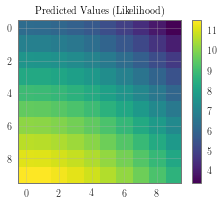

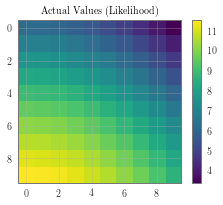

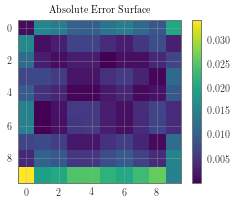

In [5]:
# Set into eval mode
model.eval()
likelihood.eval()

# Create 100 test data points
# Over the square [0,1]x[0,1]
n = 10
test_x = Variable(torch.zeros(int(pow(n, 2)), 2)).cuda()
for i in range(n):
    for j in range(n):
        test_x.data[i * n + j][0] = float(i) / (n-1)
        test_x.data[i * n + j][1] = float(j) / (n-1)

# Put the test data through the model then likelihood
observed_pred = likelihood(model(test_x))
# the mean of the Gaussians are our predicted labels
pred_labels = observed_pred.mean().view(n, n).data.cpu().numpy()

# Calculate the true test values
test_y_actual = ((torch.sin(test_x.data[:, 0]) + torch.cos(test_x.data[:, 1])) * (2 * math.pi))
test_y_actual = test_y_actual.cpu().numpy().reshape(n, n)
# Compute absolute error
delta_y = numpy.absolute(pred_labels - test_y_actual)

# Define a plotting function
def ax_plot(f, ax, y_labels, title):
    im = ax.imshow(y_labels)
    ax.set_title(title)
    f.colorbar(im)

# Make a plot of the predicted values
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax, pred_labels, 'Predicted Values (Likelihood)')
# Make a plot of the actual values
f, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax2, test_y_actual, 'Actual Values (Likelihood)')
# Make a plot of the errors
f, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax3, delta_y, 'Absolute Error Surface')